# Training a model on forces and energies

In addition to the energy, machine learning models can also be used to model molecular forces.
These are $N_\mathrm{atoms} \times 3$ arrays describing the Cartesian force acting on each atom due to the overall
(potential) energy. They are formally defined as the negative gradient of the energy $E_\mathrm{pot}$ with respect to
the nuclear positions $\mathbf{R}$

\begin{equation}
\mathbf{F}^{(\alpha)} = -\frac{\partial E_\mathrm{pot}}{\partial \mathbf{R}^{(\alpha)}},
\end{equation}

where $\alpha$ is the index of the nucleus.

The above expression offers a straightforward way to include forces in machine learning models by simply defining a
model for the energy and taking the appropriate derivatives.
The resulting model can directly be trained on energies and forces.
Moreover, in this manner energy conservation and the correct behaviour under rotations of the molecule is guaranteed.

Using forces in addition to energies to construct a machine learning model offers several advantages.
Accurate force predictions are important for molecular dynamics simulations, which will be covered in the subsequent
tutorial. Forces also encode a greater wealth of information than the energies.
For every molecule, only one energy is present, while there are $3N_\mathrm{atoms}$ force entries.
This property, combined with the fact that reference forces can be computed at the same cost as energies, makes models
trained on forces and energies very data efficient.

In the following, we will show how to train such force models and how to use them in practical applications.

## Preparing the data

The process of preparing the data is similar to the tutorial on [QM9](tutorial_02_qm9.ipynb). We begin by importing all
relevant packages and generating a directory for the tutorial experiments.

In [1]:
import torch
import torchmetrics
import schnetpack as spk
import schnetpack.transform as trn
import pytorch_lightning as pl
import os
import matplotlib.pyplot as plt
import numpy as np

forcetut = './forcetut'
if not os.path.exists(forcetut):
    os.makedirs(forcetut)

Next, the data needs to be loaded from a suitable dataset. 
For convenience, we use the MD17 dataset class provided in SchNetPack, which automatically downloads and builds suitable
databases containing energies and forces for a range of small organic molecules.
In this case, we use the ethanol molecule as an example.

In [2]:
from schnetpack.datasets import MD17

ethanol_data = MD17(
    os.path.join(forcetut,'ethanol.db'),
    molecule='ethanol',
    batch_size=10,
    num_train=1000,
    num_val=1000,
    transforms=[
        trn.ASENeighborList(cutoff=5.),
        trn.RemoveOffsets(MD17.energy, remove_mean=True, remove_atomrefs=False),
        trn.CastTo32()
    ],
    num_workers=1,
    pin_memory=True, # set to false, when not using a GPU
)
ethanol_data.prepare_data()
ethanol_data.setup()

/home/kschuett/anaconda3/envs/spkdev/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:73: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/kschuett/anaconda3/envs/spkdev/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:77: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/kschuett/anaconda3/envs/spkdev/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:81: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/kschuett/anaconda3/envs/spkdev/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:114: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation

The data is split into training (1000 points), validation (1000 points) and test set (remainder).
Once again, we subtract the mean of the energies in the training data with a preprocessing transform to precondition
our model. This only needs to be done for the energies, since the forces are obtained as derivatives and automatically
capture the scale of the data. The subtraction of atomic reference energies is not necessary here, since only molecules
of the same composition are used.

For custom datasets, the data would have to be loaded via the SchNetPack `ASEAtomsData` and `AtomsDataModule` classes
(see tutorial on [data preparation](tutorial_01_preparing_data.ipynb)). In this case, one needs to make sure that the
naming of properties is kept consistent with the config. The `schnetpack.properties` module provides standard names
for a wide range of properties. Here, we use the definitions provided with the `MD17` class.

In order to train force models, forces need to be included in the reference data.
Once the dataset has been loaded, this can be checked as follows:

In [3]:
properties = ethanol_data.dataset[0]
print('Loaded properties:\n', *['{:s}\n'.format(i) for i in properties.keys()])

Loaded properties:
 _idx
 energy
 forces
 _n_atoms
 _atomic_numbers
 _positions
 _cell
 _pbc



As can be seen, `energy` and `forces` are included in the properties dictionary. To have a look at the `forces` array
and check whether it has the expected dimensions, we can call:

In [4]:
print('Forces:\n', properties[MD17.forces])
print('Shape:\n', properties[MD17.forces].shape)



Forces:
 tensor([[ 1.4517e+00,  6.0192e+00,  5.2068e-07],
        [ 1.7953e+01, -5.1624e+00,  3.4900e-07],
        [-4.0884e+00,  2.2590e+01,  3.3088e-06],
        [-1.1416e+00, -9.7469e+00,  7.6473e+00],
        [-1.1416e+00, -9.7469e+00, -7.6473e+00],
        [-2.4821e+00,  4.9335e+00,  4.3700e+00],
        [-2.4821e+00,  4.9335e+00, -4.3700e+00],
        [-5.5148e+00, -3.0207e+00, -8.9093e-09],
        [-2.4393e+00, -1.0838e+01, -6.0721e-08]], dtype=torch.float64)
Shape:
 torch.Size([9, 3])


## Building the model

After having prepared the data in the above way, we can now build and train the force model.
This is done in the same three steps as described in [QM9 tutorial](tutorial_02_qm9.ipynb):

1. Defining input modules
2. Building the representation
3. Defining an output module

For the representation we can use the same layers as in the previous tutorial:

In [5]:
cutoff = 5.
n_atom_basis = 30

pairwise_distance = spk.atomistic.PairwiseDistances() # calculates pairwise distances between atoms
radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=cutoff)
schnet = spk.representation.SchNet(
    n_atom_basis=n_atom_basis, n_interactions=3,
    radial_basis=radial_basis,
    cutoff_fn=spk.nn.CosineCutoff(cutoff)
)

Since we want to model forces, we need an additional output module. We will still use the Atomwise to predict the
energy. However, since the forces should be described as the derivative of the energy, we have to indicate that the
corresponding derviative of the model should be computed.

This is done with the ``Forces`` module, which computes the negative derivative of the energy
 (specified by the supplied ``energy_key``) with respect to the atom positions.

In [6]:
pred_energy = spk.atomistic.Atomwise(n_in=n_atom_basis, output_key=MD17.energy)
pred_forces = spk.atomistic.Forces(energy_key=MD17.energy, force_key=MD17.forces)

The input, representation and output modules are then assembled to the neural network potential:

In [7]:
nnpot = spk.model.NeuralNetworkPotential(
    representation=schnet,
    input_modules=[pairwise_distance],
    output_modules=[pred_energy, pred_forces],
    postprocessors=[
        trn.CastTo64(),
        trn.AddOffsets(MD17.energy, add_mean=True, add_atomrefs=False)
    ]
)

## Training the model

Before we can train the model, the training task has to be defined, including the model, loss functions and
optimizers. First, the outputs of the models are connected to their respective loss functions using `ModelOutput`.
To train the model on energies and forces, we will use a combined loss function:

\begin{equation}
\mathcal{L}(E_\mathrm{ref},\mathbf{F}_\mathrm{ref},E_\mathrm{pred}, \mathbf{F}_\mathrm{pred}) = \frac{1}{n_\text{train}} \sum_{n=1}^{n_\text{train}} \left[  \rho_1 \left( E_\mathrm{ref} - E_\mathrm{pred} \right)^2 + \frac{\rho_2}{3N_\mathrm{atoms}} \sum^{N_\mathrm{atoms}}_\alpha \left\| \mathbf{F}_\mathrm{ref}^{(\alpha)} - \mathbf{F}_\mathrm{pred}^{(\alpha)} \right\|^2 \right],
\end{equation}

where we take the predicted forces to be:

\begin{equation}
\mathbf{F}_\mathrm{pred}^{(\alpha)} = -\frac{\partial E_\mathrm{pred}}{\partial \mathbf{R}^{(\alpha)}}.
\end{equation}

We have introduced the loss weights $\rho_i$ in order to control the tradeoff between energy and force loss.
In SchNetPack, we can implement such a weighted loss function by setting the loss weights of `ModelOutput`:

In [8]:
output_energy = spk.task.ModelOutput(
    name=MD17.energy,
    loss_fn=torch.nn.MSELoss(),
    loss_weight=0.01,
    metrics={
        "MAE": torchmetrics.MeanAbsoluteError()
    }
)

output_forces = spk.task.ModelOutput(
    name=MD17.forces,
    loss_fn=torch.nn.MSELoss(),
    loss_weight=0.99,
    metrics={
        "MAE": torchmetrics.MeanAbsoluteError()
    }
)

Now, the training task can be assembled as in the last tutorial:


In [9]:
task = spk.task.AtomisticTask(
    model=nnpot,
    outputs=[output_energy, output_forces],
    optimizer_cls=torch.optim.AdamW,
    optimizer_args={"lr": 1e-4}
)

Finally, we train the model using the PyTorch Lightning `Trainer` for 5 epochs.

In [10]:
logger = pl.loggers.TensorBoardLogger(save_dir=forcetut)
callbacks = [
    spk.train.ModelCheckpoint(
        inference_path=os.path.join(forcetut, "best_inference_model"),
        save_top_k=1,
        monitor="val_loss"
    )
]

trainer = pl.Trainer(
    callbacks=callbacks,
    logger=logger,
    default_root_dir=forcetut,
    max_epochs=5, # for testing, we restrict the number of epochs
)
trainer.fit(task, datamodule=ethanol_data)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/kschuett/anaconda3/envs/spkdev/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1582: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(
/home/kschuett/anaconda3/envs/spkdev/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(

  | Name    | Type                   | Params
---------------------------------------------------
0 | model   | NeuralNetworkPotential | 16.4 K
1 | outputs | ModuleList             | 0     
---------------------------------------------------
16.4 K    Trainable params
0         Non-trainable params
16.4 K    Total params
0.066     Total estimat

Validation sanity check: 0it [00:00, ?it/s]

/home/kschuett/anaconda3/envs/spkdev/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/kschuett/anaconda3/envs/spkdev/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/kschuett/anaconda3/envs/spkdev/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the numbe

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training will produce several files in the `model_path` directory, which is `forcetut` in our case.
The split is stored in `split.npz`. 
Checkpoints are written to `checkpoints` periodically, which can be used to restart training.
A copy of the best model is stored as `best_inference_model`, which can directly be accessed using the `torch.load`
function.

You can have a look at the log using Tensorboard:
```
tensorboard --logdir=forcetut/default
```

It should be noted that the model trained here is used exclusively for demonstrative purposes. Accordingly, its size
and the training time have been reduced significantly. This puts strong constraints on the accuracy that can be
obtained. For practical applications, one would e.g. increase the number of features, the interaction layers, the
learning rate schedule and train until convergence (removing the `n_epochs` keyword from the `trainer`).
To quickly get started training state-of-the-art models, have a look at the command line interface,
which comes with a series of pre-built configurations.

## Using the model

Since all models in SchNetPack are stored in the same way, we can use the trained force model in exactly the same manner
as described in the [QM9 tutorial](tutorial_02_qm9.ipynb). To load the model stored in the `best_inference_model` file,
we use the `torch.load` function. It will automatically be moved to the device it was trained on.

In [11]:
best_model = torch.load(os.path.join(forcetut, 'best_inference_model'))

## Interface to ASE

As was shown in the [QM9 tutorial](tutorial_02_qm9.ipynb), we use the `AtomsConverter` to directly operate on
ASE atoms objects.
Having access to molecular forces also makes it possible to perform a variety of different simulations.
The `SpkCalculator` offers a simple way to perform all computations available in the ASE package.
Below, we create an ASE calculator from the trained model and the previously generated `atoms` object
(see [Preparing the data](#Preparing-the-data)).
One important point is, that the MD17 dataset uses kcal/mol and kcal/mol/&#8491; as units for energies and forces.
For the ASE interface, these need to be converted to the standard internal ASE units eV and eV/&#8491;.
Therefore, we need to pass the units of the energies and forces predicted by the model to the calculator.

In [12]:
from ase import Atoms


converter = spk.interfaces.AtomsConverter(neighbor_list=trn.ASENeighborList(cutoff=5.), dtype=torch.float32)

calculator = spk.interfaces.SpkCalculator(
    model=best_model,
    converter=converter,
    energy=MD17.energy,
    forces=MD17.forces,
    energy_units='kcal/mol',
    forces_units='kcal/mol/Ang'
)

structure = ethanol_data.test_dataset[0]
atoms = Atoms(numbers=structure[spk.properties.Z], positions=structure[spk.properties.R])
atoms.set_calculator(calculator)

print('Prediction:')
print('energy:', atoms.get_total_energy())
print('forces:', atoms.get_forces())

Prediction:
energy: -4214.8652794460095
forces: [[ 3.56254085  1.82367757  1.55830998]
 [ 0.99315922 -0.86904191 -1.50720566]
 [ 0.03677444 -0.65425532 -0.1600646 ]
 [-1.86923201  1.35359331 -0.7541254 ]
 [ 0.55044083 -1.28889362 -1.43034696]
 [-1.82220995  0.88389853 -0.10380705]
 [-1.17435485 -0.84933002  1.70828506]
 [ 0.18244644 -0.75103004 -0.51986529]
 [-0.4595651   0.35138193  1.20882014]]


Among the simulations which can be done by using ASE and a force model are geometry optimisation,
normal mode analysis and simple molecular dynamics simulations.

The `AseInterface` of SchNetPack offers a convenient way to perform basic versions of these computations.
Only a file specifying the geometry of the molecule and a pretrained model are needed.

We will first generate a XYZ file containing an ethanol configuration:

In [13]:
from ase import io

# Generate a directory for the ASE computations
ase_dir = os.path.join(forcetut, 'ase_calcs')

if not os.path.exists(ase_dir):
    os.mkdir(ase_dir)

# Write a sample molecule
molecule_path = os.path.join(ase_dir, 'ethanol.xyz')
io.write(molecule_path, atoms, format='xyz')

The `AseInterface` is initialized by passing the path to the molecule, the model and a computation directory.
In addition, the computation device for the force model and how energies and forces are called in the output,
as well as their units, need to be provided.

In [14]:
ethanol_ase = spk.interfaces.AseInterface(
    molecule_path,
    ase_dir,
    best_model,
    converter=converter,
    energy=MD17.energy,
    forces=MD17.forces,
    energy_units='kcal/mol',
    forces_units='kcal/mol/Ang'
)

### Geometry optimization

For some applications it is neccessary to relax a molecule to an energy minimum.
In order to perform this optimization of the molecular geometry, we can simply call

In [15]:
ethanol_ase.optimize(fmax=1e-2)

                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 17:46:06    -4214.865279        4.2949
BFGSLineSearch:    1[  2] 17:46:06    -4215.271684        1.6134
BFGSLineSearch:    2[  4] 17:46:07    -4215.343626        0.6966
BFGSLineSearch:    3[  6] 17:46:07    -4215.392868        1.0173
BFGSLineSearch:    4[  8] 17:46:07    -4215.460684        0.5116
BFGSLineSearch:    5[ 10] 17:46:07    -4215.483194        0.6698
BFGSLineSearch:    6[ 12] 17:46:07    -4215.522721        0.6229
BFGSLineSearch:    7[ 14] 17:46:07    -4215.549195        0.5787
BFGSLineSearch:    8[ 16] 17:46:07    -4215.558430        0.4029
BFGSLineSearch:    9[ 17] 17:46:07    -4215.575628        0.3189
BFGSLineSearch:   10[ 18] 17:46:07    -4215.584439        0.6328
BFGSLineSearch:   11[ 20] 17:46:08    -4215.594228        0.5697
BFGSLineSearch:   12[ 21] 17:46:08    -4215.600722        0.3565
BFGSLineSearch:   13[ 23] 17:46:08    -4215.609511        0.3455
BFGSLineSearch:   14[ 25]

Since we trained only a reduced model, the accuracy of energies and forces is not optimal and several steps are
needed to optimize the geometry.

### Normal mode analysis

Once the geometry was optimized, normal mode frequencies can be obtained from the Hessian (matrix of second derivatives)
of the molecule. The Hessian is a measure of the curvature of the potential energy surface and normal mode frequencies
are useful for determining, whether an optimization has reached a minimum. Using the `AseInterface`, normal mode
frequencies can be obtained via:

In [16]:
ethanol_ase.compute_normal_modes()

---------------------
  #    meV     cm^-1
---------------------
  0    1.4i     11.6i
  1    0.8i      6.5i
  2    0.6i      4.9i
  3    0.1i      0.5i
  4    0.1       0.7
  5    0.1       0.9
  6   14.5     117.1
  7   36.0     290.2
  8   38.1     307.3
  9   55.8     449.7
 10   82.5     665.7
 11   95.6     770.8
 12  100.6     811.4
 13  109.9     886.7
 14  111.5     899.1
 15  124.6    1005.2
 16  136.7    1102.8
 17  154.4    1245.3
 18  160.1    1291.7
 19  163.2    1316.2
 20  166.6    1343.6
 21  365.4    2947.4
 22  370.3    2986.8
 23  373.1    3009.1
 24  375.7    3030.5
 25  387.9    3129.0
 26  406.7    3280.6
---------------------
Zero-point energy: 1.915 eV


Imaginary frequencies indicate, that the geometry optimisation has not yet reached a minimum.
The `AseInterface` also creates an `normal_modes.xyz` file which can be used to visualize the vibrations with jmol.

### Molecular dynamics

Finally, it is also possible to basic run molecular dynamics simulations using this interface.
To do so, we first need to prepare the system, where we specify the simulation file.
This routine automatically initializes the velocities of the atoms to a random number corresponding to a certain average
kinetic energy.

In [17]:
ethanol_ase.init_md(
    'simulation'
)

/home/kschuett/anaconda3/envs/spkdev/lib/python3.8/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


The actual simulation is performed by calling the function `run_md` with a certain number of steps:

In [18]:
ethanol_ase.run_md(1000)

During simulation, energies and geometries are logged to `simulation.log` and `simulation.traj`, respectively.

We can for example visualize the evolution of the systems total and potential energies as


Average temperature:     140.88 K


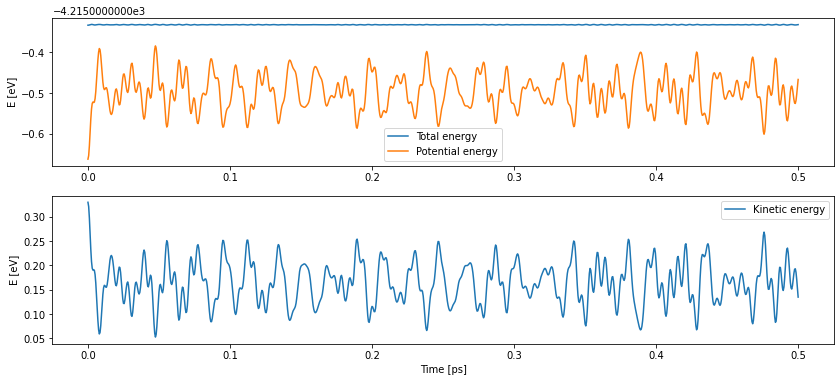

In [19]:
# Load logged results
results = np.loadtxt(os.path.join(ase_dir, 'simulation.log'), skiprows=1)

# Determine time axis
time = results[:,0]

# Load energies
energy_tot = results[:,1]
energy_pot = results[:,2]
energy_kin = results[:,3]

# Construct figure
plt.figure(figsize=(14,6))

# Plot energies
plt.subplot(2,1,1)
plt.plot(time, energy_tot, label='Total energy')
plt.plot(time, energy_pot, label='Potential energy')
plt.ylabel('E [eV]')
plt.legend()

plt.subplot(2,1,2)
plt.plot(time, energy_kin, label='Kinetic energy')
plt.ylabel('E [eV]')
plt.xlabel('Time [ps]')
plt.legend()

temperature = results[:,4]
print('Average temperature: {:10.2f} K'.format(np.mean(temperature)))

plt.show()

As can be seen, the potential and kinetic energies fluctuate, while the total energy (sum of potential and kinetic
energy) remains approximately constant. This is a good demonstration for the energy conservation obtained by modeling
forces as energy derivatives. Unfortunately, this also means that energy conservation is not a sufficient measure for
the quality of the potential.

However, frequently one is interested in simulations where the system is coupled to an external heat bath.
This is the same as saying that we wish to keep the average kinetic energy of the system and hence temperature close to a
certain value. Currently, the average temperature only depends on the random velocities drawn during the initialization
of the dynamics. Keeping a constant temperature average can be achieved by using a so-called thermostat.
In the `AseInterface`, simulations with a thermostat (to be precise a Langevin thermostat) can be carried out by
providing the `temp_bath` keyword. A simulation with e.g. the target temperature of 300K is performed via:

In [20]:
ethanol_ase.init_md(
    'simulation_300K',
    temp_bath=300,
    reset=True
)
ethanol_ase.run_md(20000)

/home/kschuett/anaconda3/envs/spkdev/lib/python3.8/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


We can now once again plot total and potential energies.
Instead of the kinetic energy, we plot the temperature (both quantities are directly related).

Average temperature:     311.14 K


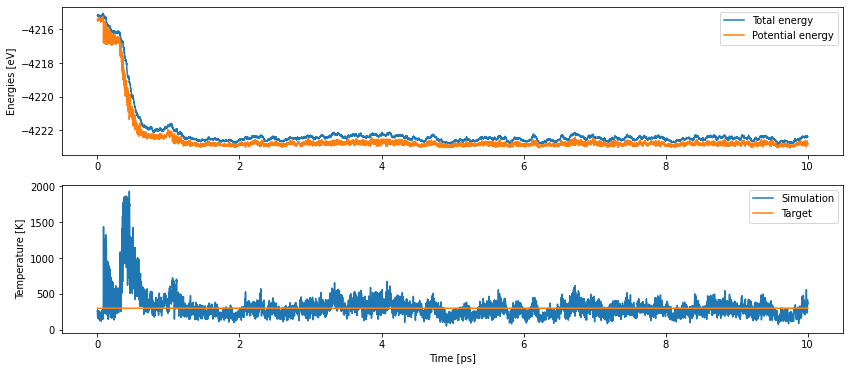

In [21]:
# Load logged results
results = np.loadtxt(os.path.join(ase_dir, 'simulation_300K.log'), skiprows=1)

# Determine time axis
time = results[:,0]
#0.02585
# Load energies
energy_tot = results[:,1]
energy_pot = results[:,2]

# Construct figure
plt.figure(figsize=(14,6))

# Plot energies
plt.subplot(2,1,1)
plt.plot(time, energy_tot, label='Total energy')
plt.plot(time, energy_pot, label='Potential energy')
plt.ylabel('Energies [eV]')
plt.legend()

# Plot Temperature
temperature = results[:,4]

# Compute average temperature
print('Average temperature: {:10.2f} K'.format(np.mean(temperature)))

plt.subplot(2,1,2)
plt.plot(time, temperature, label='Simulation')
plt.ylabel('Temperature [K]')
plt.xlabel('Time [ps]')
plt.plot(time, np.ones_like(temperature)*300, label='Target')
plt.legend()
plt.show()

Since our molecule is now subjected to external influences via the thermostat the total energy is no longer conserved.
However, the simulation temperature now fluctuates near to the requested 300K.
This can also be seen by computing the temperature average over time, which is now close to the desired value in contrast to the previous simulation.

## Summary

In this tutorial, we have trained a SchNet model on energies and forces using the MD17 ethanol dataset as an example. 
We have then evaluated the performance of the model and performed geometry optimisation, normal mode analysis and basic molecular dynamic simulations using the SchNetPack ASE interface.

While these simulations can already be useful for practical applications, SchNetPack also comes with its own molecular dynamics package.
This package makes it possible to run efficient simulations on GPU and also offers access to advanced techniques, such as ring polymer dynamics.
In the next tutorial, we will cover how to perform molecular dynamics simulations directly with SchNetPack.